# Gradient-based optimization

## Overview

Mitsuba 3 can be used to solve inverse problems involving light using a technique known as *differentiable rendering*. It interprets the rendering algorithm as a function $f(\mathbf{x})$ that converts an input $\mathbf{x}$ (the scene description) into an output $\mathbf{y}$ (the rendering). This function $f$ is then mathematically differentiated to obtain $\frac{d\mathbf{y}}{d\mathbf{x}}$, providing a first-order approximation of how a desired change in the output $\mathbf{y}$ (the rendering) can be achieved by changing the inputs $\mathbf{x}$ (the scene description). Together with a differentiable *objective function* $g(\mathbf{y})$ that quantifies the suitability of tentative scene parameters, a gradient-based optimization algorithm such as stochastic gradient descent or Adam can then be used to find a sequence of scene parameters $\mathbf{x_0}$, $\mathbf{x_1}$, $\mathbf{x_2}$, etc., that successively improve the objective function. In pictures:

![](autodiff_figure.jpg)


In this tutorial, we will build a simple example application that showcases differentiation and optimization through a light transport simulation:

1. We will first render a reference image of the Cornell Box scene.
2. Then, we will perturb the color of one of the walls, e.g. changing it to blue.
3. Finally, we will try to recover the original color of the wall using differentiation along with the reference image generated in step 1.

Mitsuba’s ability to automatically differentiate entire rendering algorithms builds on differentiable JIT array types provided by the Dr.Jit library. Those are explained in the [Dr.Jit documentation][1]. The linked document also discusses key differences compared to related frameworks like PyTorch and TensorFlow. For *automatic differentiation* (AD), Dr.Jit records and simplifies computation graphs and uses them to propagate derivatives in forward or reverse mode. Before getting further into this tutorial, we recommend that you familiarize yourself Dr.Jit.

<div class="admonition important alert alert-block alert-success">

🚀 **You will learn how to:**
    
<ul>
  <li>Pass scene arguments when loading an XML file</li>
  <li>Build an optimization loop using the <code>Optimizer</code> classes</li>
  <li>Perform a gradient-based optimization using automatic differentiation</li>
</ul>
    
</div>

    
[1]: https://drjit.readthedocs.io/en/master/

## Setup

In order to use the automatic differentiation, we need to enable a variant that supports it. Those are the ones containing `_ad` after the backend description. E.g. `cuda_ad_rgb`, `llvm_ad_rgb`, …


<div class="admonition important alert alert-block alert-info">
    
If you receive an error mentionning that the requested variant is not supported, you can switch to another available `_ad` variant. If you compiled Mitsuba 3 yourself, you can also add the desired variant to your `build/mitsuba.conf` file and recompile the project ([documentation][1]).

[1]: https://mitsuba.readthedocs.io/en/latest/src/developer_guide/compiling.html#configuring-mitsuba-conf

</div>

In [1]:
import drjit as dr
import mitsuba as mi

mi.set_variant('llvm_ad_rgb')

## Scene loading

Before loading the scene, let's note that in `cbox.xml`, we expose some variables at the top of the file:

```xml
  <default name="spp" value="128"/>
  <default name="res" value="256"/>
  <default name="max_depth" value="6"/>
  <default name="integrator" value="path"/>
```

Those variables are later referenced in the XML file, as explained in the [XML scene format documentation][1].
They can be given new values directly from Python when loading the scene by passing keyword arguments to the `load_file()` function. This helpful feature let us change the film resolution and integrator type for this tutorial without editing the XML file.

For this simple differentiable rendering example, which does not involve moving objects or cameras, we recommand using the Path Replay Backpropagation integrator ([<code>prb</code>][2]) introduced by <cite data-cite="Vicini2021">Vicini et al. (2021)</cite>. It is essentially a path tracer, augmented with a specialized algorithm to efficiently compute the gradients in a separate <i>adjoint</i> pass.

[1]: https://mitsuba.readthedocs.io/en/latest/src/key_topics/scene_format.html
[2]: https://mitsuba.readthedocs.io/en/latest/src/api_reference.html#mitsuba.ad.integrators.prb

In [2]:
scene = mi.load_file('../scenes/cbox.xml', res=128, integrator='prb')

## Reference image

We render a reference image of the original scene that will later be used in the objective function for the optimization. Ideally, this reference image should expose very little noise as it will pertube optimization process otherwise. For best results, we should render it with an even larger sample count.

In [3]:
image_ref = mi.render(scene, spp=512)

# Preview the reference image
mi.util.convert_to_bitmap(image_ref)

Bitmap[
  pixel_format = rgb,
  component_format = uint8,
  size = [128, 128],
  srgb_gamma = 1,
  struct = Struct<3>[
    uint8 R; // @0, normalized, gamma, premultiplied alpha
    uint8 G; // @1, normalized, gamma, premultiplied alpha
    uint8 B; // @2, normalized, gamma, premultiplied alpha
  ],
  data = [ 48 KiB of image data ]
]

## Initial state

Using the `traverse` mechanism, we can pick the parameter that we will be optimizing and change its value away from the correct value. The goal of the optimization process will be to recover the original value of this parameter using gradient descent. 

We chose the `'red.reflectance.value'` parameter, which controls the albedo color of the red wall in the scene.
For later comparison, we also save the original value of the scene parameter.

In [4]:
params = mi.traverse(scene)

key = 'red.reflectance.value'

# Save the original value
param_ref = mi.Color3f(params[key])

# Set another color value and update the scene
params[key] = mi.Color3f(0.01, 0.2, 0.9)
params.update();

As expected, when rendering the scene again, the wall has changed color.

In [5]:
image_init = mi.render(scene, spp=128)
mi.util.convert_to_bitmap(image_init)

Bitmap[
  pixel_format = rgb,
  component_format = uint8,
  size = [128, 128],
  srgb_gamma = 1,
  struct = Struct<3>[
    uint8 R; // @0, normalized, gamma, premultiplied alpha
    uint8 G; // @1, normalized, gamma, premultiplied alpha
    uint8 B; // @2, normalized, gamma, premultiplied alpha
  ],
  data = [ 48 KiB of image data ]
]

## Optimization

For gradient-based optimization, Mitsuba ships with standard optimizers including *Stochastic Gradient Descent* ([<code>SGD</code>][1]) with and without momentum, as well as [<code>Adam</code>][2] <cite data-cite="kingma2014adam">[KB14]</cite>. We will instantiate the latter and optimize our scene parameter with a learning rate of `0.05`. 

We then set the color to optimize on the optimizer, which will now hold a copy of this parameter and enable gradient tracking on it. During the optimization process, the optimizer will always perfom gradient steps on those variables. To propagate those changes to the scene, we need to call the `update()` method which will copy the values back into the `params` data structure. As always this method also notifies all objects in the scene whose parameters have changed, in case they need to update their internal state.

This first call to `params.update()` ensures that gradient tracking with respect to our wall color parameter is propagated to the scene internal state. For more detailed explanation on how-to-use the optimizer classes, please refer to the dedicated [how-to-guide][3].

[1]: https://mitsuba.readthedocs.io/en/latest/src/api_reference.html#mitsuba.ad.SGD
[2]: https://mitsuba.readthedocs.io/en/latest/src/api_reference.html#mitsuba.ad.Adam
[3]: https://mitsuba.readthedocs.io/en/latest/src/how_to_guides/use_optimizers.html

In [6]:
opt = mi.ad.Adam(lr=0.05)
opt[key] = params[key]
params.update(opt);

At every iteration of the gradient descent, we will compute the derivatives of the scene parameters with respect to the objective function. In this simple experiment, we use the [*mean square error*][1], or $L_2$ error, between the current image and the reference created above.

[1]: https://en.wikipedia.org/wiki/Mean_squared_error

In [7]:
def mse(image):
    return dr.mean(dr.square(image - image_ref))

In the following cell we define the hyper parameters controlling our optimization loop, such as the number of iterations:

In [8]:
iteration_count = 50

In [9]:
# IGNORE THIS: When running under pytest, adjust parameters to reduce computation time
import os
if 'PYTEST_CURRENT_TEST' in os.environ:
    iteration_count = 2

It is now time to actually perform the gradient-descent loop that executes 50 differentiable rendering iterations.

In [10]:
errors = []
for it in range(iteration_count):
    # Perform a (noisy) differentiable rendering of the scene
    image = mi.render(scene, params, spp=4)
    
    # Evaluate the objective function from the current rendered image
    loss = mse(image)

    # Backpropagate through the rendering process
    dr.backward(loss)

    # Optimizer: take a gradient descent step
    opt.step()

    # Post-process the optimized parameters to ensure legal color values.
    opt[key] = dr.clip(opt[key], 0.0, 1.0)

    # Update the scene state to the new optimized values
    params.update(opt)
    
    # Track the difference between the current color and the true value
    err_ref = dr.sum(dr.square(param_ref - params[key]))
    print(f"Iteration {it:02d}: parameter error = {err_ref}", end='\r')
    errors.append(err_ref.array[0])
print('\nOptimization complete.')

Iteration 49: parameter error = [0.00143229]
Optimization complete.


## Results

We can now render the scene again to check whether the optimization process successfully recovered the color of the red wall.

In [11]:
image_final = mi.render(scene, spp=128)
mi.util.convert_to_bitmap(image_final)

Bitmap[
  pixel_format = rgb,
  component_format = uint8,
  size = [128, 128],
  srgb_gamma = 1,
  struct = Struct<3>[
    uint8 R; // @0, normalized, gamma, premultiplied alpha
    uint8 G; // @1, normalized, gamma, premultiplied alpha
    uint8 B; // @2, normalized, gamma, premultiplied alpha
  ],
  data = [ 48 KiB of image data ]
]

It worked!

Note visualizing the objective value directly sometimes gives limited information, since differences between `image` and `image_ref` can be dominated by Monte Carlo noise that is not related to the parameter being optimized. 

Since we know the “true” target parameter in this scene, we can validate the convergence of the optimization by checking the difference to the true color at each iteration:

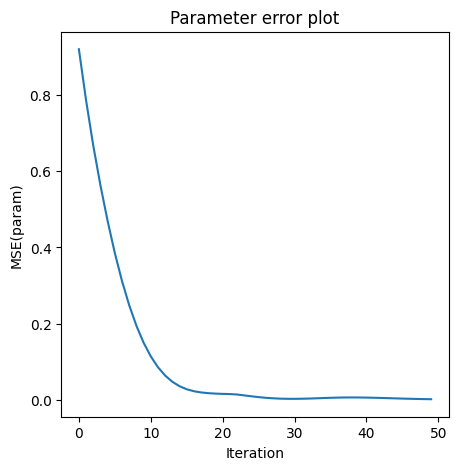

In [12]:
import matplotlib.pyplot as plt
plt.plot(errors)
plt.xlabel('Iteration'); plt.ylabel('MSE(param)'); plt.title('Parameter error plot');
plt.show()

## See also

- [Detailed look at <code>Optimizer</code>](https://mitsuba.readthedocs.io/en/latest/src/how_to_guides/use_optimizers.html)
- API reference:
  - [<code>mitsuba.ad.Optimizer</code>](https://mitsuba.readthedocs.io/en/latest/src/api_reference.html#mitsuba.ad.Optimizer)
  - [<code>prb</code> plugin](https://mitsuba.readthedocs.io/en/latest/src/generated/plugins_integrators.html#path-replay-backpropagation-prb)
  - [<code>mitsuba.ad.SGD</code>](https://mitsuba.readthedocs.io/en/latest/src/api_reference.html#mitsuba.ad.SGD)
  - [<code>mitsuba.ad.Adam</code>](https://mitsuba.readthedocs.io/en/latest/src/api_reference.html#mitsuba.ad.Adam)
  - [<code>drjit.backward</code>](https://drjit.readthedocs.io/en/latest/reference.html#drjit.backward)